<a href="https://colab.research.google.com/github/VIVEKPATIL12/DS_Combined/blob/main/wetSubclassification_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [4]:
import zipfile

In [6]:
zip_ref = zipfile.ZipFile('/content/WetSubclassificationData.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

classes = ["Asphilt_wet","cobaltstone_wet","Concreate_wet","gravel_wet","Heavy_wet","muddy_wet","slight_wet"] # replace with your actual class names
data_dir = '/content/WetSubclassificationData'
train_dir = 'content/train/'
test_dir = 'content/test/'

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    # Create class-specific train and test directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Get a list of all image files for this class
    image_files = os.listdir(os.path.join(data_dir, cls))

    # Split the files into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)  # 80% train, 20% test

    # Copy the train files into the train directory
    for file in train_files:
        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(train_dir, cls, file))

    # Copy the test files into the test directory
    for file in test_files:
        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(test_dir, cls, file))




In [8]:
# Train the Model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import scipy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/content/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')




Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [9]:
# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(7, activation="softmax")(headModel)  # Change the number here according to your number of classes

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# # Train the model
# model.fit(train_generator, validation_data=test_generator, epochs=2)

# # Save the model
# model.save('model.h5')




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 442s 25s/step - accuracy: 0.4283 - loss: 1.6047 - val_accuracy: 0.6643 - val_loss: 0.8714
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 510s 29s/step - accuracy: 0.7984 - loss: 0.6102 - val_accuracy: 0.7429 - val_loss: 0.7127
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 447s 25s/step - accuracy: 0.8633 - loss: 0.4318 - val_accuracy: 0.7643 - val_loss: 0.6904
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 442s 25s/step - accuracy: 0.9080 - loss: 0.2920 - val_accuracy: 0.7643 - val_loss: 0.6763
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 441s 25s/step - accuracy: 0.9351 - loss: 0.2394 - val_accuracy: 0.7500 - val_loss: 0.7237


Found 560 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 349s 19s/step


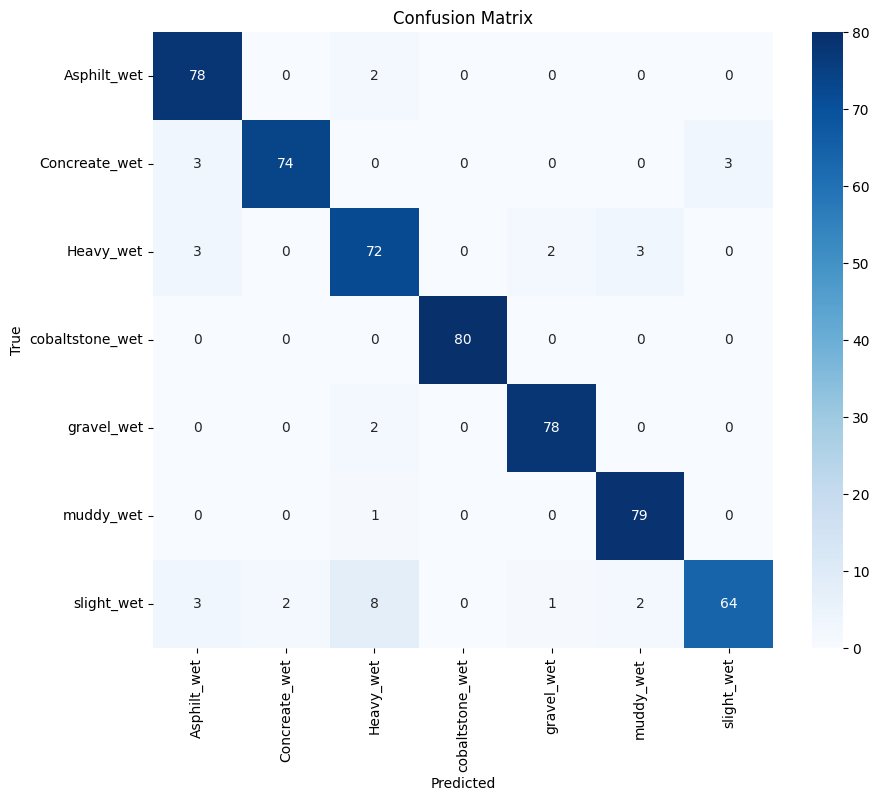

                 precision    recall  f1-score   support

    Asphilt_wet       0.90      0.97      0.93        80
  Concreate_wet       0.97      0.93      0.95        80
      Heavy_wet       0.85      0.90      0.87        80
cobaltstone_wet       1.00      1.00      1.00        80
     gravel_wet       0.96      0.97      0.97        80
      muddy_wet       0.94      0.99      0.96        80
     slight_wet       0.96      0.80      0.87        80

       accuracy                           0.94       560
      macro avg       0.94      0.94      0.94       560
   weighted avg       0.94      0.94      0.94       560



In [11]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Load the test data
test_generator = test_datagen.flow_from_directory(
    '/content/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 140 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 17s/step


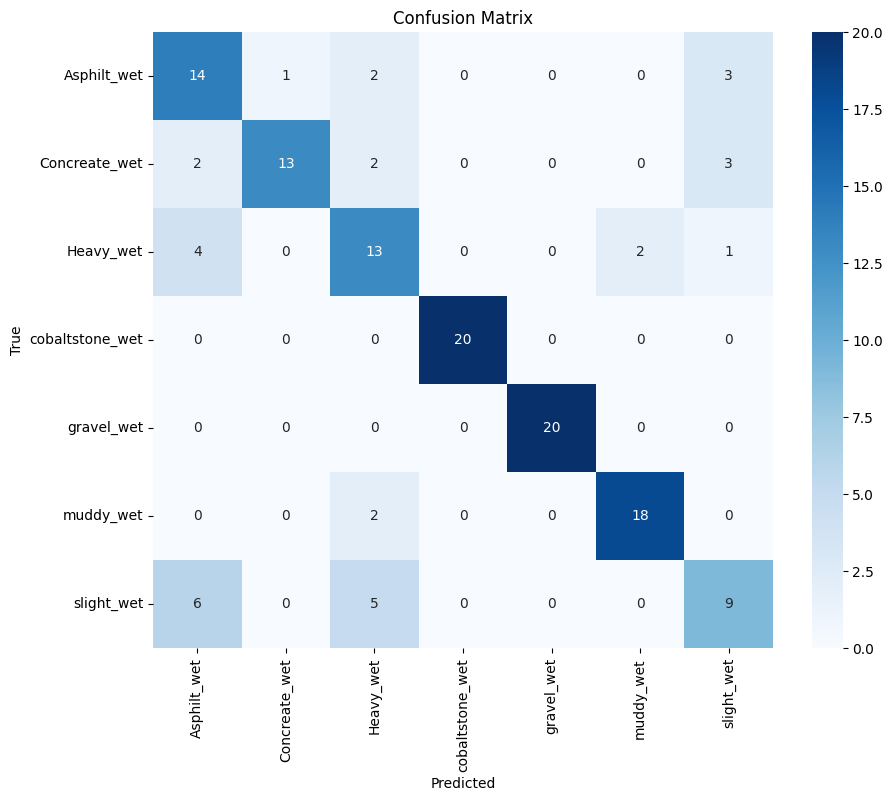

                 precision    recall  f1-score   support

    Asphilt_wet       0.54      0.70      0.61        20
  Concreate_wet       0.93      0.65      0.76        20
      Heavy_wet       0.54      0.65      0.59        20
cobaltstone_wet       1.00      1.00      1.00        20
     gravel_wet       1.00      1.00      1.00        20
      muddy_wet       0.90      0.90      0.90        20
     slight_wet       0.56      0.45      0.50        20

       accuracy                           0.76       140
      macro avg       0.78      0.76      0.77       140
   weighted avg       0.78      0.76      0.77       140



In [12]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Load the test data
test_generator = test_datagen.flow_from_directory(
    '/content/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


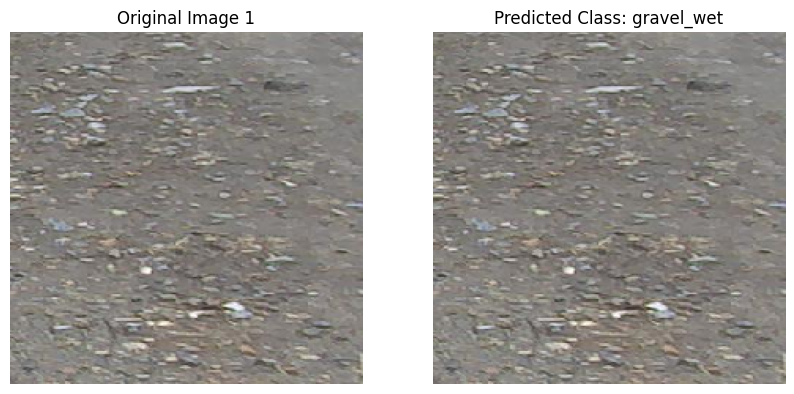

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


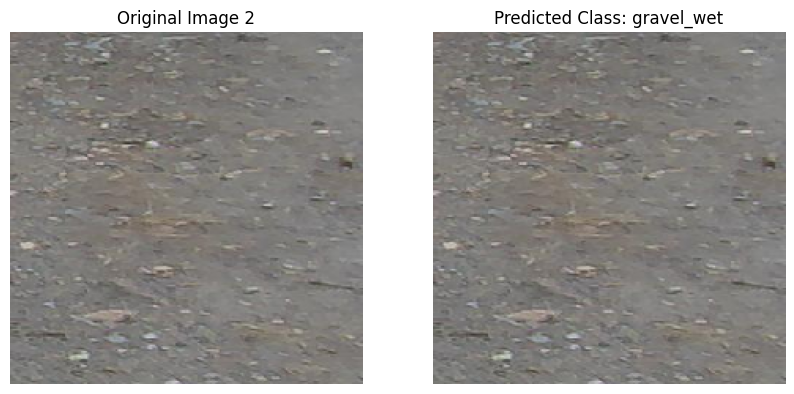

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


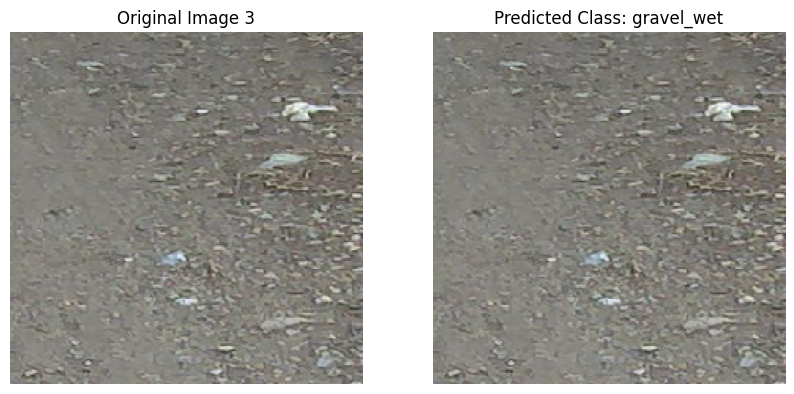

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


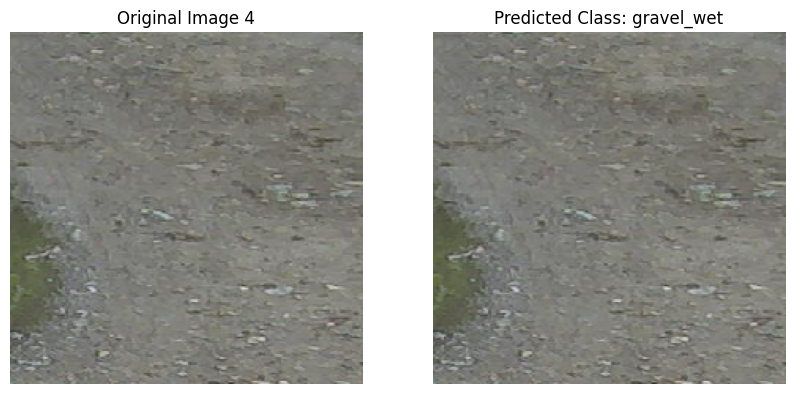

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


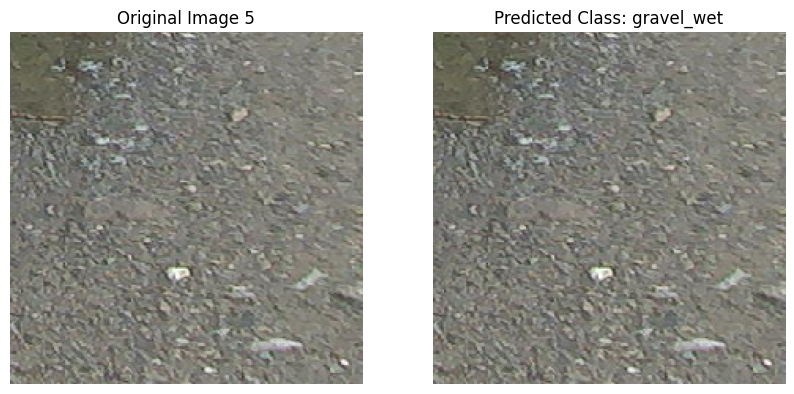

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


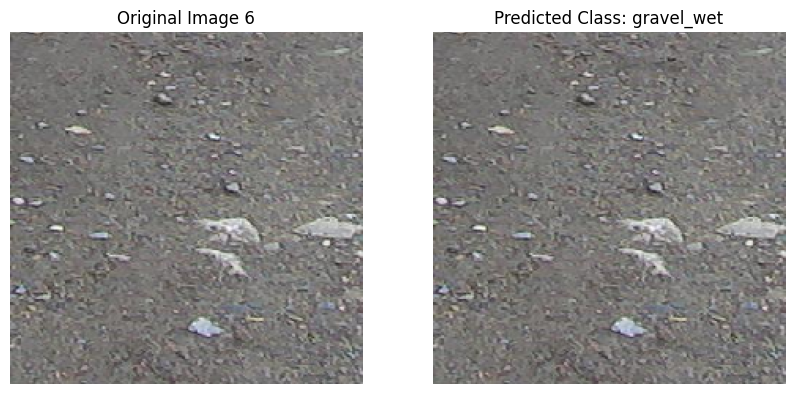

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


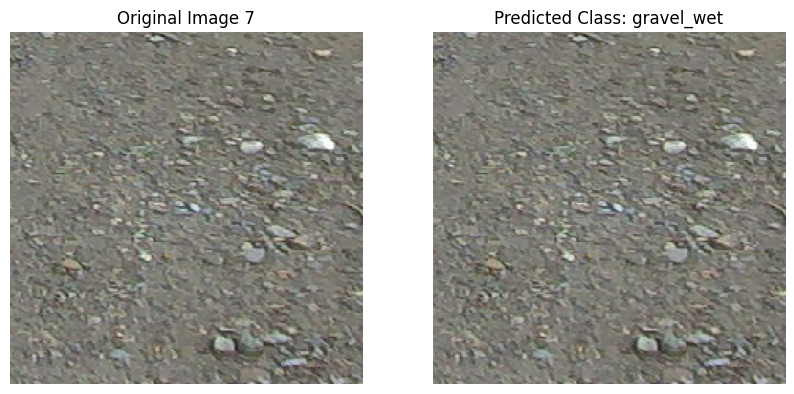

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


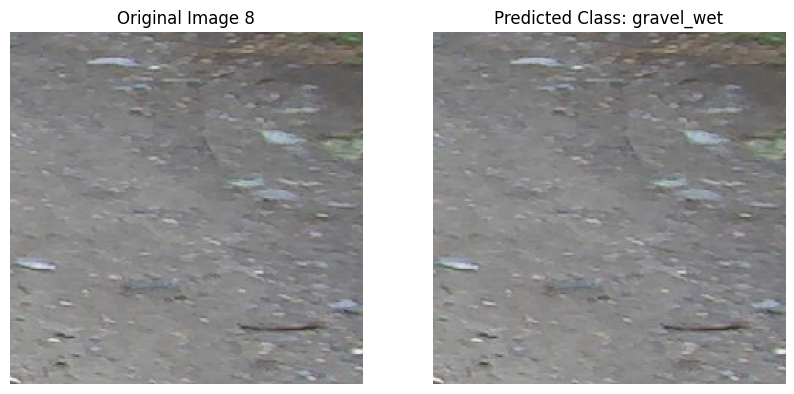

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


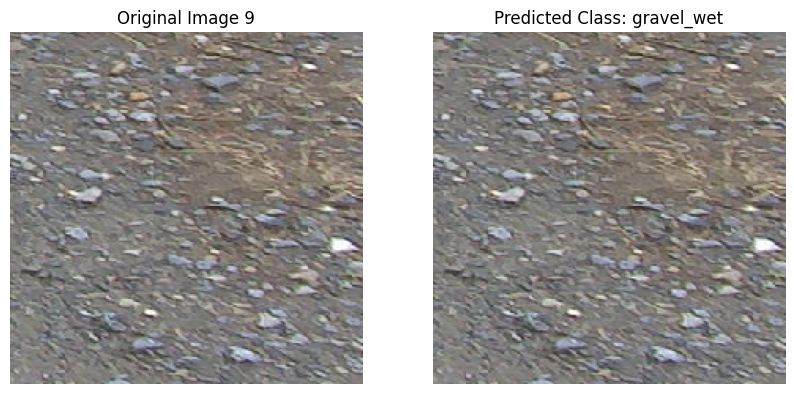

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


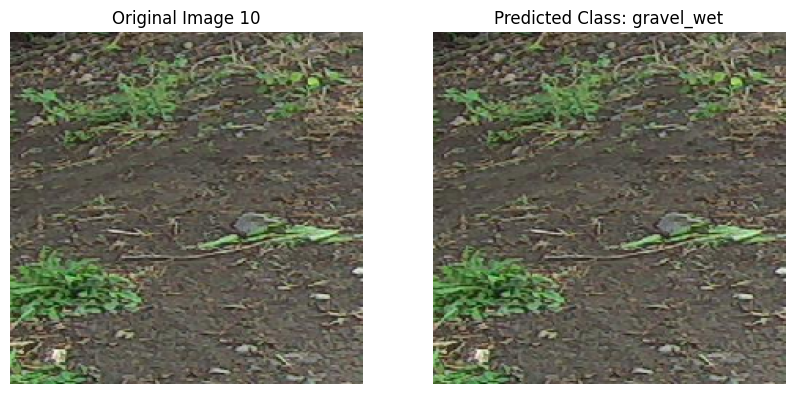

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


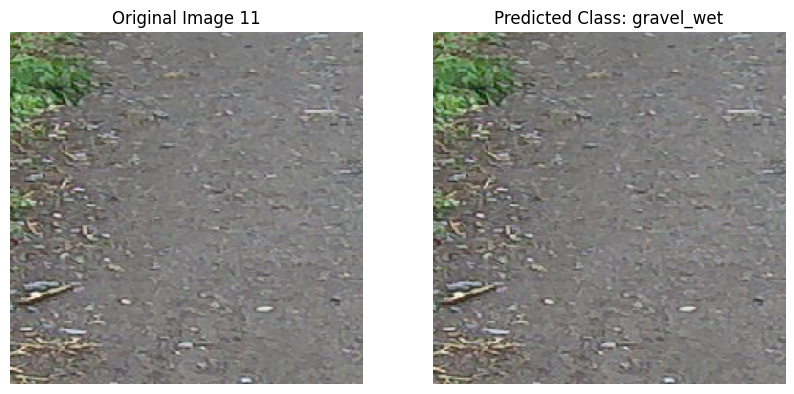

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


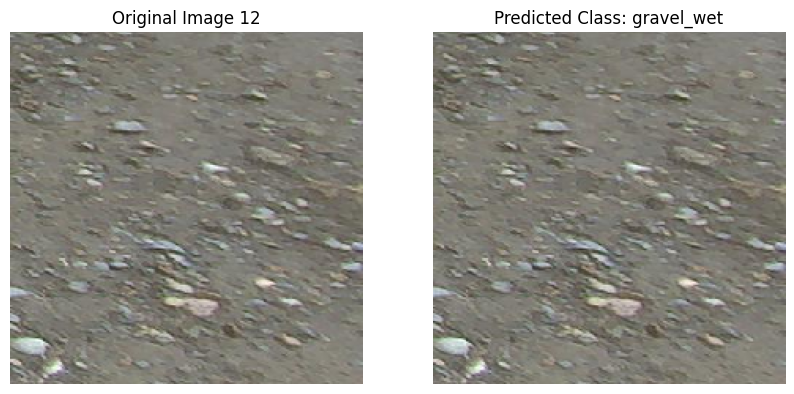

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


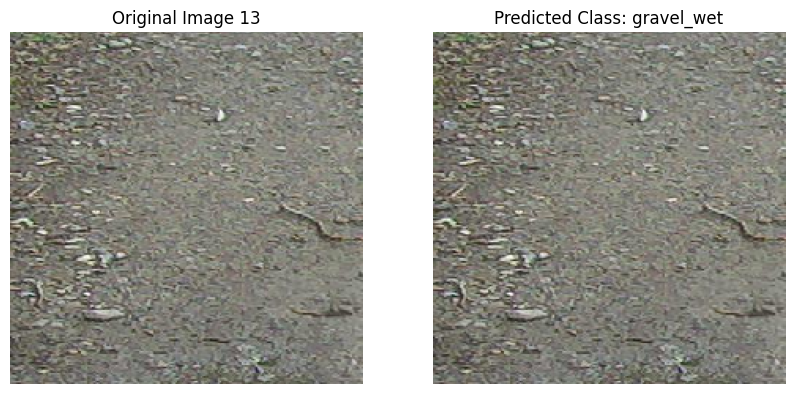

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


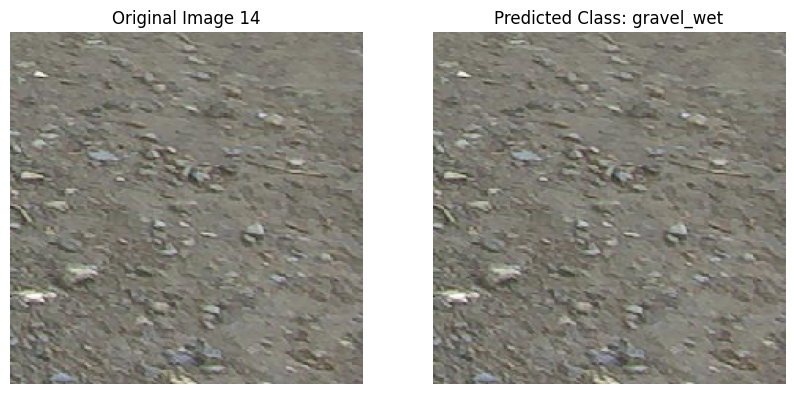

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


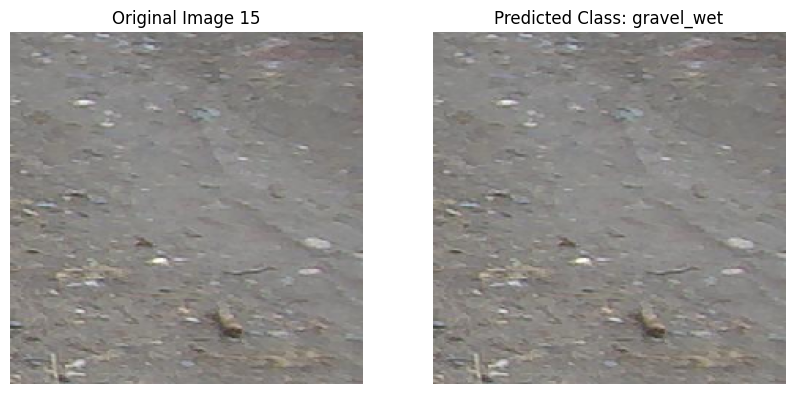

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


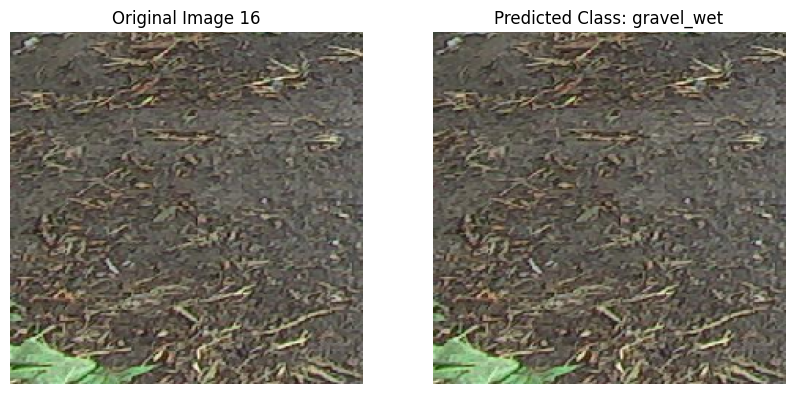

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


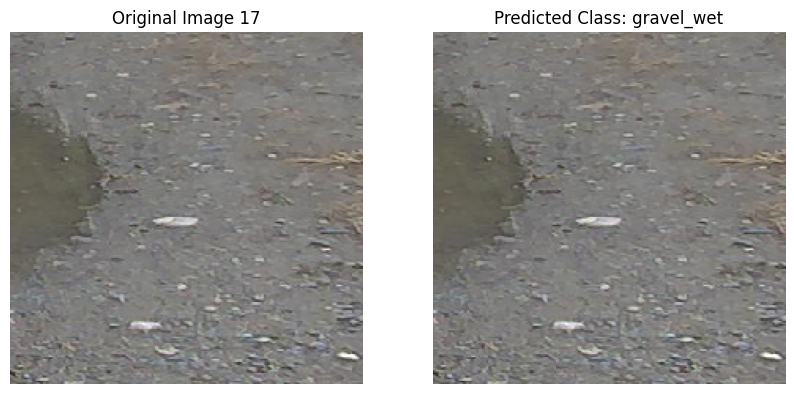

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


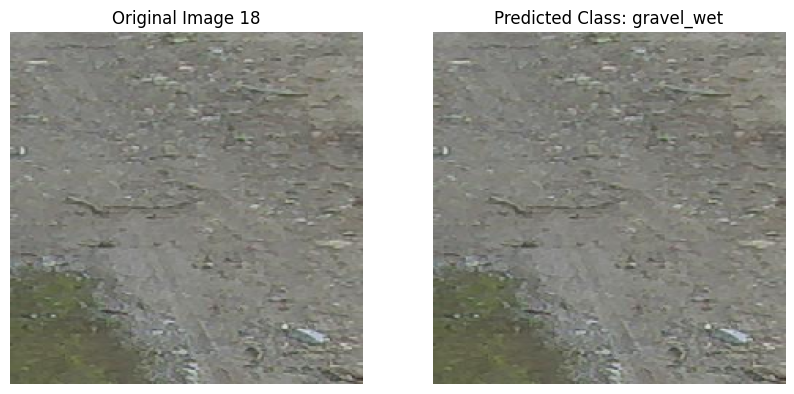

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


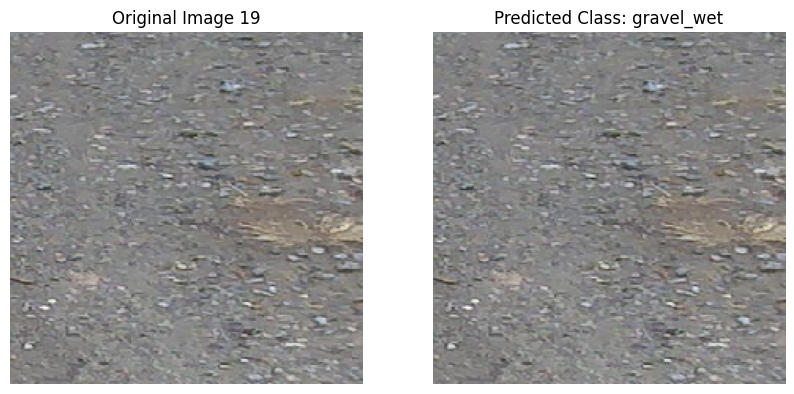

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


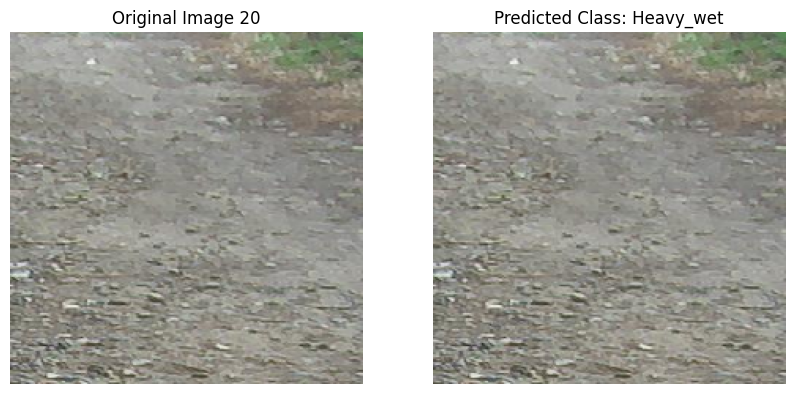

In [22]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the directory path
dir_path = '/content/content/test/gravel_wet'

# Get the list of files in the directory
files = os.listdir(dir_path)

# Iterate over the files
for i, file in enumerate(files):
    # Load the image
    new_image = image.load_img(os.path.join(dir_path, file), target_size=(img_height, img_width))

    # Preprocess the image
    new_image_array = image.img_to_array(new_image)
    new_image_array = np.expand_dims(new_image_array, axis=0)

    # Use the model to classify the image
    predictions = model.predict(new_image_array)
    predicted_class_index = np.argmax(predictions, axis=1)

    # Get the class labels from the train_generator
    class_labels = list(train_generator.class_indices.keys())

    # Print the predicted class name
    predicted_class_name = class_labels[predicted_class_index[0]]

    # Display the original image and predicted class label
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(new_image)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicted class: cobaltstone_wet


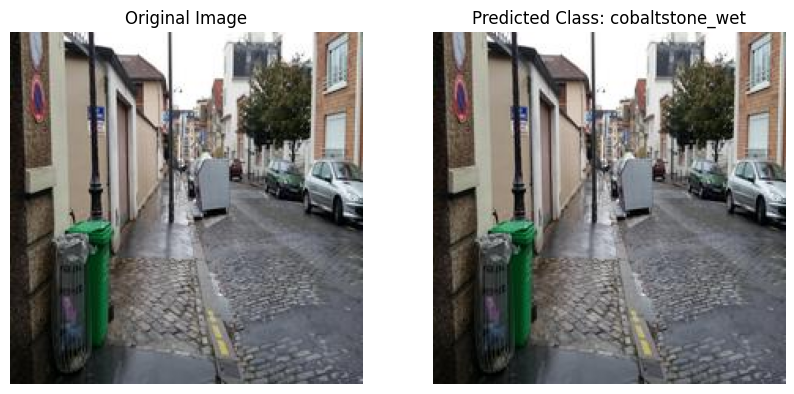

In [27]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Load the pre-trained model
model = load_model('best_model.keras')

# Define the class labels
classes = ["Asphilt_wet","cobaltstone_wet","Concreate_wet","gravel_wet","Heavy_wet","muddy_wet","slight_wet"] # replace with your actual class names


# Load the external image
img_path = '/content/RhVgIvbICMiY5B3IH_xjZg.jpg'
img = plt.imread(img_path)

# # Preprocess the image (resize, normalize pixel values)
# img_height, img_width = 224, 224
# img = img.resize((img_height, img_width))
# img = img / 255.0  # Normalize the pixel values

# Add a batch dimension (since Keras models expect a batch of images as input)
img = np.expand_dims(img, axis=0)

# Make predictions on the preprocessed image
predictions = model.predict(img)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Print the predicted class label
predicted_class_name = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

# Display the original image and predicted class label
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title(f'Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img[0])
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()